In [1]:
!pip install camb
!pip install healpy
!pip install emcee
!pip install corner

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import camb
import healpy as hp
import emcee
import pickle
import corner

In [3]:
def sim(v = [67.5 , 0.022, 0.122, 0.06,  0.06, 3.05, 0.965]):
    """ Generate a temperature power spectrum given cosmological parameters"""
    """ v = [H0, ombh2, omch2, mnu, tau, logA, ns]  """
    V=v
    H0 , ombh2, omch2, mnu, tau, logA, ns = V[0], V[1], V[2], V[3], V[4], V[5], V[6]
    As = 1e-10 * np.exp(logA)
    pars = camb.CAMBparams()
    try:
        pars.set_cosmology( H0 = H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
        pars.InitPower.set_params(As=As, ns=ns, r=0)
        pars.set_for_lmax(2500, lens_potential_accuracy=0);
        pars.NonLinear = camb.model.NonLinear_none
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        totCL = powers['total'][:, 0]
        nside = 1024
        cmb_map = hp.sphtfunc.synfast(totCL, nside=nside)
        cl = hp.sphtfunc.anafast(cmb_map)
        return totCL[30:2499], cl[30:2499]
    except:
        print('Failed simulation')
        return None


In [4]:
fiducial_v = [67.5 , 0.022, 0.122, 0.06,  0.06, 3.05, 0.965]
observed_v = [69 , 0.025, 0.11, 0.064,  0.054, 3.01, 0.94]

fid_cl, fid_cl_hat = sim(fiducial_v)
obs_cl, obs_cl_hat = sim(observed_v)
ells = np.arange(0, 2500)[30:2499]

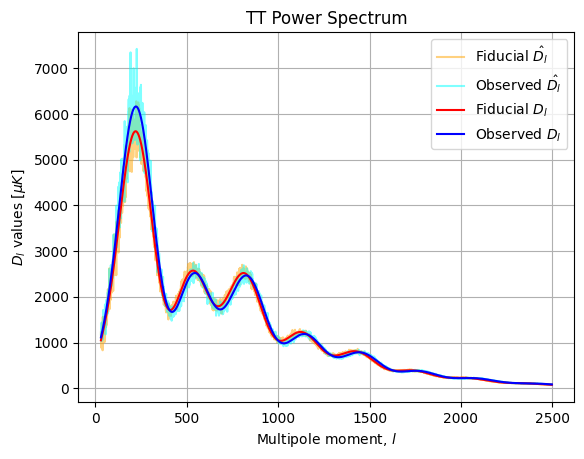

In [5]:
plt.plot(ells, fid_cl_hat, color = 'orange', alpha = 0.5, label = r'Fiducial $\hat{D_l}$')
plt.plot(ells, obs_cl_hat, color = 'cyan', alpha = 0.5, label = r'Observed $\hat{D_l}$')
plt.plot(ells, fid_cl, color = 'red', alpha = 1.0, label = r'Fiducial $D_l$')
plt.plot(ells, obs_cl, color = 'blue', alpha = 1.0, label = r'Observed $D_l$')
plt.xlabel(r'Multipole moment, $l$')
plt.ylabel(r'$D_l$ values [$\mu K$]')
plt.title('TT Power Spectrum')
plt.legend()
plt.grid()

In [6]:
def calc_cov_theory(cl, ls):
    '''
    A function that calculates the covariance matrix
    Assumes that Cls are given for 30<l<2500
    
    Parameters
    ----------
    cl: ndarray or list 
        1D array or list of Cls 
        
    Returns
    -------
    A covariance matrix (NxN)
    '''
    return (np.diag(2 / (2 * ls + 1)  * cl**2))

def log_likelihood(observed_cl_hats, fiducial_cl_hats, cov_matrix):
    d_minus_mu = observed_cl_hats - fiducial_cl_hats
    d_minus_mu_vector = [[i] for i in d_minus_mu ]
    e_factor = -0.5*np.matmul(np.transpose(d_minus_mu_vector), np.matmul(np.linalg.inv(cov_matrix), d_minus_mu_vector))
    factor = (np.sqrt(2*np.pi*np.linalg.norm(cov_matrix)))
    return e_factor - np.log(factor)

def lnL(v):
    sim_cl, sim_cl_hat = sim(v)
    ells = np.arange(1, 2500)[30:2499]
    cov = calc_cov_theory(sim_cl, ells)
    return log_likelihood(sim_cl_hat, fid_cl, cov)

def log_prior(v):
    V=v
    H0 , ombh2, omch2, mnu, tau, logA, ns = V[0], V[1], V[2], V[3], V[4], V[5], V[6]
    if 50 < H0 < 90 and 0.01 < ombh2 < 0.05 and 0.01 < omch2 < 0.5 and 0.04 < mnu < 0.08 and 0.02 < tau < 0.9 and 1.5 < logA < 3.5 and 0.8 < ns < 1.0:
        return 0.0
    return -np.inf

def wrapper(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta)

In [7]:
nwalkers, ndim = 20, 7
p0 = [50 , 0.01, 0.01, 0.04,  0.02, 1.5, 0.8] + 1e-4 * np.random.randn(nwalkers, ndim)

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, wrapper)

In [12]:
sampler.run_mcmc(p0, 4000, progress=True)
samples = sampler.get_chain(flat=True)

  0%|          | 0/4000 [00:00<?, ?it/s]/anaconda/envs/azureml_py38/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 131/4000 [12:42<9:30:02,  8.84s/it]

In [ ]:
with open('mcmc_4000.pkl', 'wb') as f:
    pickle.dump(samples, f)

In [ ]:
fig = corner.corner(samples, smooth = 4.0, labels=["H0", "ombh2", "omch2", "mnu", "tau", "logA", "ns"],
                    truths=observed_v)  
plt.show()
print(samples.shape[0])

In [45]:
!pip install cosmoHammer
!wget https://github.com/cosmo-ethz/CosmoHammerPlugins/blob/master/wmap9Wrapper/get_wmap.sh

--2024-01-26 18:51:11--  https://github.com/cosmo-ethz/CosmoHammerPlugins/blob/master/wmap9Wrapper/get_wmap.sh
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7676 (7.5K) [text/plain]
Saving to: ‘get_wmap.sh’

get_wmap.sh         100%[===================>]   7.50K  --.-KB/s    in 0.007s  

2024-01-26 18:51:12 (1014 KB/s) - ‘get_wmap.sh’ saved [7676/7676]



In [47]:
!sudo apt-get install gfortran


Reading package lists... Done
Building dependency tree       
Reading state information... Done
gfortran is already the newest version (4:9.3.0-1ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.


In [51]:
!git clone https://github.com/cosmo-ethz/CosmoHammerPlugins.git

Cloning into 'CosmoHammerPlugins'...
remote: Enumerating objects: 286, done.
remote: Total 286 (delta 0), reused 0 (delta 0), pack-reused 286
Receiving objects: 100% (286/286), 361.17 KiB | 926.00 KiB/s, done.
Resolving deltas: 100% (121/121), done.
Updating files: 100% (222/222), done.


In [55]:
%cd CosmoHammerPlugins


/mnt/batch/tasks/shared/LS_root/mounts/clusters/ab34201/code/Users/ab3420/CosmoHammerPlugins


In [71]:
%cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ab34201/code/Users/ab3420/CosmoHammerPlugins


In [56]:

!ls


README.rst   classWrapper     pycambWrapper  wmap5Wrapper  wmap9Wrapper
cambWrapper  planck13Wrapper  wmap3Wrapper   wmap7Wrapper


In [72]:
%cd wmap9Wrapper


/mnt/batch/tasks/shared/LS_root/mounts/clusters/ab34201/code/Users/ab3420/CosmoHammerPlugins/wmap9Wrapper


In [73]:
!bash get_wmap.sh
!python setup.py build
!python setup.py install --user


trying do get wmap_likelihood_full_v5.tar.gz from http://lambda.gsfc.nasa.gov/data/map/dr5/dcp/likelihood/
URL transformed to HTTPS due to an HSTS policy
--2024-01-26 19:22:39--  https://lambda.gsfc.nasa.gov/data/map/dr5/dcp/likelihood/wmap_likelihood_full_v5.tar.gz
Resolving lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)... 129.164.179.68, 2001:4d0:2310:150::68
Connecting to lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)|129.164.179.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 950684664 (907M) [application/x-gzip]
Saving to: ‘wmap_likelihood_full_v5.tar.gz.1’

wmap_likelihood_ful 100%[===================>] 906.64M  1.61MB/s    in 9m 27s  

2024-01-26 19:32:07 (1.60 MB/s) - ‘wmap_likelihood_full_v5.tar.gz.1’ saved [950684664/950684664]

wmap_likelihood_v5/
wmap_likelihood_v5/br_mod_dist.f90
wmap_likelihood_v5/read_fits.fh
wmap_likelihood_v5/WMAP_9yr_tetbeebbeb_pixlike.F90
wmap_likelihood_v5/read_fits.f90
wmap_likelihood_v5/WMAP_9yr_teeebb_pixlike.F90
wmap_like

In [63]:
%cd cambWrapper

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ab34201/code/Users/ab3420/CosmoHammerPlugins/cambWrapper


In [64]:
!python setup.py build
!python setup.py install --user

running build
running build_py
creating build
creating build/lib
creating build/lib/cambWrapper
copying cambWrapper/CambCoreModule.py -> build/lib/cambWrapper
copying cambWrapper/__init__.py -> build/lib/cambWrapper
creating build/lib/test
copying test/testCambWrapper.py -> build/lib/test
copying test/__init__.py -> build/lib/test
running egg_info
creating cambWrapper.egg-info
writing cambWrapper.egg-info/PKG-INFO
writing dependency_links to cambWrapper.egg-info/dependency_links.txt
writing requirements to cambWrapper.egg-info/requires.txt
writing top-level names to cambWrapper.egg-info/top_level.txt
writing manifest file 'cambWrapper.egg-info/SOURCES.txt'
reading manifest file 'cambWrapper.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'

adding license file 'LICENSE'
adding license file 'AUTHORS.rst'
writing manifest file 'cambWrapper.egg-info/SOURCES.txt'
running install
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/setuptools/command/install.py:34: Setuptools

In [67]:
!which python


/anaconda/envs/azureml_py38/bin//python


In [68]:
!python -m site


sys.path = [
    '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ab34201/code/Users/ab3420/CosmoHammerPlugins/cambWrapper',
    '/anaconda/envs/azureml_py38/lib/python38.zip',
    '/anaconda/envs/azureml_py38/lib/python3.8',
    '/anaconda/envs/azureml_py38/lib/python3.8/lib-dynload',
    '/home/azureuser/.local/lib/python3.8/site-packages',
    '/home/azureuser/.local/lib/python3.8/site-packages/cambWrapper-0.3.0-py3.8.egg',
    '/anaconda/envs/azureml_py38/lib/python3.8/site-packages',
]
USER_BASE: '/home/azureuser/.local' (exists)
USER_SITE: '/home/azureuser/.local/lib/python3.8/site-packages' (exists)
ENABLE_USER_SITE: True


In [74]:
!ls /home/azureuser/.local/lib/python3.8/site-packages


cambWrapper-0.3.0-py3.8.egg  easy-install.pth


In [75]:
"""
Runs CosmoHammer with the CambWrapper and WMAPWrapper.
The CosmoHammer will sample with 50*7 Walker for 2*250 iterations.

"""
import sys
sys.path.append('CosmoHammerPlugins/wmap9Wrapper')

from cosmoHammer import MpiCosmoHammerSampler
from cosmoHammer import LikelihoodComputationChain
from cosmoHammer.util import Params

from wmap9Wrapper import WmapExtLikelihoodModule as wmap9
from cambWrapper import CambCoreModule


#parameter start center, min, max, start width
params = Params(("hubble",                [70, 65, 80, 3]),
                ("ombh2",                 [0.0226, 0.01, 0.03, 0.001]),
                ("omch2",                 [0.122, 0.09, 0.2, 0.01]),
                ("scalar_amp",            [2.1e-9, 1.8e-9, 2.35e-9, 1e-10]),
                ("scalar_spectral_index", [0.96, 0.8, 1.2, 0.02]),
                ("re_optical_depth",      [0.09, 0.01, 0.1, 0.03]),
                ("sz_amp",                [1,0,2,0.4]))

chain = LikelihoodComputationChain(
                    min=params[:,1], 
                    max=params[:,2])

camb_mod = CambCoreModule.CambCoreModule()

chain.addCoreModule(camb_mod)

chain.addLikelihoodModule(wmap9.WmapExtLikelihoodModule())

chain.setup()


sampler = MpiCosmoHammerSampler(
                params= params, 
                likelihoodComputationChain=chain, 
                filePrefix="cosmoHammerWmap9_", 
                walkersRatio=20, 
                burninIterations=0, 
                sampleIterations=50)

print("start sampling")
sampler.startSampling()
print("done!")

ModuleNotFoundError: No module named '_wmapWrapper'